# Network Initialization

In [25]:
!pip install lark groq -q

In [26]:
from typing import Any, Callable, Literal
from tqdm.auto import tqdm
from PIL import Image, ImageDraw, ImageFont
from groq import Groq
import os
import io
import re
import base64
import random
import lark
import torch
import matplotlib.pyplot as plt

ROOT_DIR = os.getcwd()
DATASETS_DIR = os.path.join(ROOT_DIR, 'data', 'datasets')
GROQ_API_KEY = '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'

In [27]:
if not os.path.exists(DATASETS_DIR):
    os.makedirs(DATASETS_DIR)

# LTN

## FOL Grammar

In [28]:
CONSTANT_TERMINAL = 'constant'
VARIABLE_TERMINAL = 'variable'
FUNCTION_TERMINAL = 'function'
IFF_TERMINAL = 'iff'
IMPLIES_TERMINAL = 'implies'
LOGICAL_OR_TERMINAL = 'logical_or'
LOGICAL_AND_TERMINAL = 'logical_and'
LOGICAL_NOT_TERMINAL = 'logical_not'
WRAPPER_TERMINAL = 'wrapper'
FORALL_TERMINAL = 'forall'
EXISTS_TERMINAL = 'exists'
PREDICATE_TERMINAL = 'predicate'

CONSTANT_SYMBOL = 'C'
VARIABLE_SYMBOL = 'x'
FUNCTION_SYMBOL = 'f'
IFF_SYMBOL = 'iff'
IMPLIES_SYMBOL = 'implies'
LOGICAL_OR_SYMBOL = '|'
LOGICAL_AND_SYMBOL = '&'
LOGICAL_NOT_SYMBOL = '!'
WRAPPER_SYMBOL = ''
FORALL_SYMBOL = 'forall'
EXISTS_SYMBOL = 'exists'
PREDICATE_SYMBOL = 'P'

FOL_GRAMMAR = f'''
//// Explanations ////

    // {CONSTANT_TERMINAL} identifiers always start with "{CONSTANT_SYMBOL}"
    // {VARIABLE_TERMINAL} identifiers always start with "{VARIABLE_SYMBOL}"
    // {FUNCTION_TERMINAL} identifiers always start with "{FUNCTION_SYMBOL}"
    // {PREDICATE_TERMINAL} identifiers always start with "{PREDICATE_SYMBOL}"
    // equivalence symbol is "{IFF_SYMBOL}"
    // implication symbol is "{IMPLIES_SYMBOL}"
    // disjunction symbol is "{LOGICAL_OR_SYMBOL}"
    // conjunction symbol is "{LOGICAL_AND_SYMBOL}"
    // negation symbol is "{LOGICAL_NOT_SYMBOL}"
    // wrapper symbol is "{WRAPPER_SYMBOL}(" and ")"
    // existential quantifier symbol is "{EXISTS_SYMBOL}"
    // universal quantifier symbol is "{FORALL_SYMBOL}"
    // the root of the outcome tree is always an expression

//// Initialization ////

    // imports
     %import common.WS
     %ignore WS

    // entry point
    ?start: expression

//// Term-Level Terminal Definitions  ////

    // Tree Structure:
    // term
    // ├─atom
    // │ └─{CONSTANT_TERMINAL}, {VARIABLE_TERMINAL}
    // └─mapper
    //   └─{FUNCTION_TERMINAL}

    // Implicit Level-1 Terminal (no precedence)
    ?term: atom | mapper

    // Implicit Level-2 Terminals (no precedence)
    ?atom: {CONSTANT_TERMINAL} | {VARIABLE_TERMINAL}
    ?mapper: {FUNCTION_TERMINAL}

    // Explicit Terminals (no precedence)
    {CONSTANT_TERMINAL}: /{CONSTANT_SYMBOL}[a-z0-9_]*/
    {VARIABLE_TERMINAL}: /{VARIABLE_SYMBOL}[a-z0-9_]*/
    {FUNCTION_TERMINAL}: /{FUNCTION_SYMBOL}[a-z0-9_]*/ "(" term ("," term)* ")"

//// Expression-Level Terminal Definitions ////

    // Tree Structure:
    // expression
    // ├─binary_connective
    // │ └─{IFF_TERMINAL}, {IMPLIES_TERMINAL}, {LOGICAL_OR_TERMINAL}, {LOGICAL_AND_TERMINAL}
    // ├─unary_connective
    // │ └─{LOGICAL_NOT_TERMINAL}, {WRAPPER_TERMINAL}
    // ├─quantifier
    // │ └─{EXISTS_TERMINAL}, {FORALL_TERMINAL}
    // └─evaluator
    //   └─{PREDICATE_TERMINAL}

    // Implicit Level-1 Terminal (with increasing precedence)
    ?expression: binary_connective
    ?binary_connective: equivalence
    ?equivalence: implication | {IFF_TERMINAL}
    ?implication: disjunction | {IMPLIES_TERMINAL}
    ?disjunction: conjunction | {LOGICAL_OR_TERMINAL}
    ?conjunction: auxiliary | {LOGICAL_AND_TERMINAL}
    ?auxiliary: unary_connective | quantifier | evaluator

    // Implicit Level-2 Terminals (no precedence)
    ?unary_connective: {LOGICAL_NOT_TERMINAL} | {WRAPPER_TERMINAL}
    ?quantifier: {EXISTS_TERMINAL} | {FORALL_TERMINAL}
    ?evaluator: {PREDICATE_TERMINAL}

    // Explicit Terminals (no precedence)
    {IFF_TERMINAL}: equivalence "{IFF_SYMBOL}" implication
    {IMPLIES_TERMINAL}: implication "{IMPLIES_SYMBOL}" disjunction
    {LOGICAL_OR_TERMINAL}: disjunction "{LOGICAL_OR_SYMBOL}" conjunction
    {LOGICAL_AND_TERMINAL}: conjunction "{LOGICAL_AND_SYMBOL}" auxiliary
    {LOGICAL_NOT_TERMINAL}: "{LOGICAL_NOT_SYMBOL}" expression
    {WRAPPER_TERMINAL}: "{WRAPPER_SYMBOL}(" expression ")"
    {EXISTS_TERMINAL}: "{EXISTS_SYMBOL}" {VARIABLE_TERMINAL} ("," {VARIABLE_TERMINAL})* expression
    {FORALL_TERMINAL}: "{FORALL_SYMBOL}" {VARIABLE_TERMINAL} ("," {VARIABLE_TERMINAL})* expression
    {PREDICATE_TERMINAL}: /{PREDICATE_SYMBOL}[a-z0-9_]*/ "(" term ("," term)* ")"
'''

## Groundings

In [29]:
class Grd():

    # Implicit Super Grounding
    class Base():
        def __init__(self, description:str) -> None:
            self.description = description
            self.content = None
            self.device = 'cpu'
        def __repr__(self) -> str:
            return self.__str__()
        def __str__(self) -> str:
            return self.description
        def __call__(self, *args:Any) -> Any:
            raise NotImplementedError()

    # Explicit Groundings
    class Empty(Base):
        def __init__(self) -> None:
            super().__init__('empty')
        def __call__(self) -> None:
            return None

    class Command(Base):
        def __init__(self, command:str) -> None:
            super().__init__('command')
            self.content = command
        def __call__(self) -> str:
            return self.content

    class Value(Base):
        def __init__(self, tensor:torch.Tensor) -> None:
            shape = 'scalar' if tensor.ndim == 0 else f'{tensor.shape[0]}x0' if tensor.ndim == 1 else 'x'.join(str(dim) for dim in tensor.shape)
            trainability = 'trainable' if tensor.requires_grad else 'non-trainable'
            super().__init__(f'tensor[{shape}, {trainability}]')
            self.content = tensor
        def __call__(self) -> torch.Tensor:
            return self.content

    class Network(Base):
        def __init__(self, network:torch.nn.Module) -> None:
            tot_params = sum(tensor.numel() for tensor in network.parameters())
            tot_trainable_params = sum(tensor.numel() for tensor in network.parameters() if tensor.requires_grad)
            super().__init__(f'network[{tot_params} params, {tot_trainable_params} trainable]')
            self.content = network
        def __call__(self, *args:torch.Tensor) -> torch.Tensor:
            return self.content(*args)

    class Routine(Base):
        @classmethod
        def wrap(cls, description:str) -> Callable[[Callable[..., torch.Tensor]], 'Grd.Routine']:
            def decorator(routine: Callable[..., torch.Tensor]) -> Grd.Routine:
                return Grd.Routine(staticmethod(routine), description)
            return decorator
        def __init__(self, routine:Callable[..., torch.Tensor], description:str):
            name = routine.__name__
            super().__init__(f'{name}[{description}]')
            self.content = routine
        def __call__(self, *args:torch.Tensor) -> torch.Tensor:
            return self.content(*args)

## Blocks

In [30]:
class Blk():

    # Implicit Super Block
    class Base():
        PRINT_PRIORITY = 0
        TERMINAL:str|None = None
        def __init__(self, name:str, symbol:str, *children:'Blk.Base') -> None:
            self.name = name
            self.symbol = symbol
            self.children = children
            self.current_grd:Grd.Base = Grd.Empty()
            self.default_grd_dict = {k: v for k, v in self.__class__.__dict__.items() if isinstance(v, Grd.Routine)}
            self.global_blk_list = list['Blk.Base']()
            self.global_domain_list = list[str]()
            self.involved_domain_set = set[str]()
            self.arg_shape_dict = dict[str, list[str]]()
            self.inp_shape_list = list[str]()
            self.out_shape_list = list[str]()
        def __repr__(self) -> str:
            return self.__str__()
        def __str__(self) -> str:
            raise NotImplementedError()
        def __call__(self, **value_dict:torch.Tensor) -> torch.Tensor:
            raise NotImplementedError()
        def setup_blks(self, global_blk_list:list['Blk.Base']) -> None:
            for child in self.children:
                child.setup_blks(global_blk_list)
            global_blk_list.append(self)
            self.global_blk_list = global_blk_list
        def setup_domains(self, global_domain_list:list[str]) -> None:
            for child in self.children:
                child.setup_domains(global_domain_list)
            if isinstance(self, Blk.Quantifier):
                for variable in self.children[:-1]:
                    if variable.name not in global_domain_list:
                        global_domain_list.append(variable.name)
            global_domain_list.sort()
            self.global_domain_list = global_domain_list
        def setup_shapes(self) -> None:
            for child in self.children:
                child.setup_shapes()
            if isinstance(self, Blk.Atom):
                self.out_shape_list.append('B*')
                if self.name in self.global_domain_list:
                    self.involved_domain_set = {self.name}
                    self.out_shape_list.append(f'D{self.name}')
                self.out_shape_list.append(f'E{self.name}')
            elif isinstance(self, Blk.Mapper):
                for term in self.children:
                    self.involved_domain_set.update(term.involved_domain_set)
                    self.arg_shape_dict[term.name] = term.out_shape_list
                self.out_shape_list.append('B*')
                for domain in self.global_domain_list:
                    self.out_shape_list.append(f'D{domain}' if domain in self.involved_domain_set else '1')
                self.out_shape_list.append(f'E{self.name}')
            elif isinstance(self, Blk.BinaryConnective):
                left, right = self.children
                self.involved_domain_set.update(left.involved_domain_set)
                self.involved_domain_set.update(right.involved_domain_set)
                self.arg_shape_dict['left_tensor'] = ['B*'] + [f'D{domain}*' for domain in self.global_domain_list]
                self.arg_shape_dict['right_tensor'] = ['B*'] + [f'D{domain}*' for domain in self.global_domain_list]
                self.out_shape_list = ['B*'] + [f'D{domain}*' for domain in self.global_domain_list]
            elif isinstance(self, Blk.UnaryConnective):
                body = self.children[0]
                self.involved_domain_set.update(body.involved_domain_set)
                self.arg_shape_dict['tensor'] = ['B*'] + [f'D{domain}*' for domain in self.global_domain_list]
                self.out_shape_list = ['B*'] + [f'D{domain}*' for domain in self.global_domain_list]
            elif isinstance(self, Blk.Quantifier):
                body = self.children[-1]
                self.involved_domain_set.update(self.global_domain_list)
                for variable in self.children[:-1]:
                    self.involved_domain_set.remove(variable.name)
                self.arg_shape_dict['tensor'] = ['B*'] + [f'D{domain}*' for domain in self.global_domain_list]
                self.out_shape_list = ['B*'] + [f'D{domain}**' for domain in self.global_domain_list]
            elif isinstance(self, Blk.Evaluator):
                for term in self.children:
                    self.involved_domain_set.update(term.involved_domain_set)
                    self.arg_shape_dict[term.name] = term.out_shape_list
                self.out_shape_list.append('B*')
                for domain in self.global_domain_list:
                    self.out_shape_list.append(f'D{domain}' if domain in self.involved_domain_set else '1')
        def ground(self, **context_dict:Grd.Command|Grd.Value|Grd.Network|Grd.Routine) -> None:
            if self.name in context_dict:
                temporary_ground = context_dict[self.name]
                if isinstance(temporary_ground, Grd.Command):
                    self.current_grd = self.default_grd_dict[temporary_ground()]
                else:
                    self.current_grd = temporary_ground
            for child in self.children:
                child.ground(**context_dict)

    # Implicit Level-1 Blocks
    class Term(Base):
        def __init__(self, name:str, symbol:str, *children:'Blk.Base') -> None:
            super().__init__(name, symbol, *children)

    class Expression(Base):
        def __init__(self, name:str, symbol:str, *children:'Blk.Base') -> None:
            super().__init__(name, symbol, *children)

    # Implicit Level-2 Blocks
    class Atom(Term):
        PRINT_PRIORITY = 1
        def __init__(self, name:str, symbol:str) -> None:
            super().__init__(name, symbol)
            self.current_grd:Grd.Empty|Grd.Value = Grd.Empty()
        def __str__(self) -> str:
            return self.name
        def __call__(self, **value_dict:torch.Tensor) -> torch.Tensor:
            if isinstance(self.current_grd, Grd.Empty):
                return value_dict[self.name]
            return self.current_grd()

    class Mapper(Term):
        PRINT_PRIORITY = 2
        def __init__(self, name:str, symbol:str, *terms:'Blk.Term') -> None:
            super().__init__(name, symbol, *terms)
            self.current_grd:Grd.Empty|Grd.Network|Grd.Routine = Grd.Empty()
        def __str__(self) -> str:
            return self.name + '(' + ', '.join(str(child) for child in self.children) + ')'
        def __call__(self, **value_dict:torch.Tensor) -> torch.Tensor:
            return self.current_grd(*[term(**value_dict) for term in self.children])

    class BinaryConnective(Expression):
        PRINT_PRIORITY = 4
        def __init__(self, name:str, symbol:str, default_grd:Grd.Routine, left:'Blk.Expression', right:'Blk.Expression') -> None:
            super().__init__(name, symbol, left, right)
            self.current_grd = default_grd
        def __str__(self) -> str:
            return str(self.children[0]) + ' ' + self.symbol + ' ' + str(self.children[1])
        def __call__(self, **value_dict:torch.Tensor) -> torch.Tensor:
            left, right = self.children
            return self.current_grd(left(**value_dict), right(**value_dict))

    class UnaryConnective(Expression):
        PRINT_PRIORITY = 4
        def __init__(self, name:str, symbol:str, default_grd:Grd.Routine, body:'Blk.Expression') -> None:
            super().__init__(name, symbol, body)
            self.current_grd = default_grd
        def __str__(self) -> str:
            return self.symbol + '(' + str(self.children[0]) + ')'
        def __call__(self, **value_dict:torch.Tensor) -> torch.Tensor:
            body = self.children[0]
            return self.current_grd(body(**value_dict))

    class Quantifier(Expression):
        PRINT_PRIORITY = 5
        def __init__(self, name:str, symbol:str, default_grd:Grd.Routine, body:'Blk.Expression', *variables:'Blk.Variable') -> None:
            super().__init__(name, symbol, *variables, body)
            self.current_grd = default_grd
        def __str__(self) -> str:
            return self.symbol + '[' + ', '.join(str(child) for child in self.children[:-1]) + '](' + str(self.children[-1]) + ')'
        def __call__(self, **value_dict:torch.Tensor) -> torch.Tensor:
            variable_list = self.children[:-1]
            body = self.children[-1]
            reduction_dim_list = [self.global_domain_list.index(variable.name) + 1 for variable in variable_list]
            return self.current_grd(reduction_dim_list, body(**value_dict))

    class Evaluator(Expression):
        PRINT_PRIORITY = 3
        def __init__(self, name:str, symbol:str, *terms:'Blk.Term') -> None:
            super().__init__(name, symbol, *terms)
            self.current_grd:Grd.Empty|Grd.Network|Grd.Routine = Grd.Empty()
        def __str__(self) -> str:
            return self.name + '(' + ', '.join(str(child) for child in self.children) + ')'
        def __call__(self, **value_dict:torch.Tensor) -> torch.Tensor:
            return self.current_grd(*[term(**value_dict) for term in self.children])

    # Explicit Blocks
    class Constant(Atom):
        TERMINAL = CONSTANT_TERMINAL
        def __init__(self, in_list:list[lark.Token]) -> None:
            super().__init__(in_list[0].value, CONSTANT_SYMBOL)

    class Variable(Atom):
        TERMINAL = VARIABLE_TERMINAL
        def __init__(self, in_list:list[lark.Token]) -> None:
            super().__init__(in_list[0].value, VARIABLE_SYMBOL)

    class Function(Mapper):
        TERMINAL = FUNCTION_TERMINAL
        def __init__(self, in_list:list['lark.Token|Blk.Term']) -> None:
            super().__init__(in_list[0].value, FUNCTION_SYMBOL, *in_list[1:])

    class Iff(BinaryConnective):
        TERMINAL = IFF_TERMINAL
        def __init__(self, in_list:list['Blk.Expression']) -> None:
            super().__init__(IFF_TERMINAL, IFF_SYMBOL, self.linear_similarity, in_list[0], in_list[1])
        @Grd.Routine.wrap('1 - |x1 - x2|')
        def linear_similarity(left_tensor:torch.Tensor, right_tensor:torch.Tensor) -> torch.Tensor:
            return 1.0 - torch.abs(left_tensor - right_tensor)

    class Implies(BinaryConnective):
        TERMINAL = IMPLIES_TERMINAL
        def __init__(self, in_list:list['Blk.Expression']) -> None:
            super().__init__(IMPLIES_TERMINAL, IMPLIES_SYMBOL, self.lukasiewicz, in_list[0], in_list[1])
        @Grd.Routine.wrap('min(1, 1 - x1 + x2)')
        def lukasiewicz(left_tensor:torch.Tensor, right_tensor:torch.Tensor) -> torch.Tensor:
            return torch.minimum(torch.tensor(1.0), 1 - left_tensor + right_tensor)
        @Grd.Routine.wrap('1 if x1 <= x2 else x2')
        def godel(left_tensor:torch.Tensor, right_tensor:torch.Tensor) -> torch.Tensor:
            return torch.where(left_tensor <= right_tensor, torch.tensor(1.0), right_tensor)
        @Grd.Routine.wrap('1 if x1 <=x2 else x2 / x1')
        def goguen(left_tensor:torch.Tensor, right_tensor:torch.Tensor) -> torch.Tensor:
            return torch.where(left_tensor <= right_tensor, torch.tensor(1.0), right_tensor / torch.clamp(left_tensor, min=torch.tensor(1e-6)))
        @Grd.Routine.wrap('max(1 - x1, x2)')
        def kleene_dienes(left_tensor:torch.Tensor, right_tensor:torch.Tensor) -> torch.Tensor:
            return torch.maximum(1 - left_tensor, right_tensor)

    class LogicalOr(BinaryConnective):
        TERMINAL = LOGICAL_OR_TERMINAL
        def __init__(self, in_list:list[Any]) -> None:
            super().__init__(LOGICAL_OR_TERMINAL, LOGICAL_OR_SYMBOL, self.lukasiewicz, in_list[0], in_list[1])
        @Grd.Routine.wrap('min(1, x1 + x2)')
        def lukasiewicz(left_tensor:torch.Tensor, right_tensor:torch.Tensor) -> torch.Tensor:
            return torch.minimum(torch.tensor(1.0), left_tensor + right_tensor)
        @Grd.Routine.wrap('max(x1, x2)')
        def godel(left_tensor:torch.Tensor, right_tensor:torch.Tensor) -> torch.Tensor:
            return torch.maximum(left_tensor, right_tensor)
        @Grd.Routine.wrap('1 - (1 - x1) * (1 - x2)')
        def goguen(left_tensor:torch.Tensor, right_tensor:torch.Tensor) -> torch.Tensor:
            return 1.0 - (1.0 - left_tensor) * (1.0 - right_tensor)

    class LogicalAnd(BinaryConnective):
        TERMINAL = LOGICAL_AND_TERMINAL
        def __init__(self, in_list:list['Blk.Expression']) -> None:
            super().__init__(LOGICAL_AND_TERMINAL, LOGICAL_AND_SYMBOL, self.lukasiewicz, in_list[0], in_list[1])
        @Grd.Routine.wrap('max(0, x1 + x2 - 1)')
        def lukasiewicz(left_tensor:torch.Tensor, right_tensor:torch.Tensor) -> torch.Tensor:
            return torch.maximum(torch.tensor(0.0), left_tensor + right_tensor - 1.0)
        @Grd.Routine.wrap('min(x1, x2)')
        def godel(left_tensor:torch.Tensor, right_tensor:torch.Tensor) -> torch.Tensor:
            return torch.minimum(left_tensor, right_tensor)
        @Grd.Routine.wrap('x1 * x2')
        def goguen(left_tensor:torch.Tensor, right_tensor:torch.Tensor) -> torch.Tensor:
            return  left_tensor * right_tensor

    class LogicalNot(UnaryConnective):
        TERMINAL = LOGICAL_NOT_TERMINAL
        def __init__(self, in_list:list['Blk.Expression']) -> None:
            super().__init__(LOGICAL_NOT_TERMINAL, LOGICAL_NOT_SYMBOL, self.complementation, in_list[0])
        @Grd.Routine.wrap('1 - x')
        def complementation(tensor:torch.Tensor) -> torch.Tensor:
            return 1.0 - tensor

    class Wrapper(UnaryConnective):
        TERMINAL = WRAPPER_TERMINAL
        def __init__(self, in_list:list['Blk.Expression']) -> None:
            super().__init__(WRAPPER_TERMINAL, WRAPPER_SYMBOL, self.identity, in_list[0])
        @Grd.Routine.wrap('x')
        def identity(tensor:torch.Tensor) -> torch.Tensor:
            return tensor

    class Exists(Quantifier):
        TERMINAL = EXISTS_TERMINAL
        def __init__(self, in_list:list['Blk.Variable|Blk.Expression']) -> None:
            super().__init__(EXISTS_TERMINAL, EXISTS_SYMBOL, self.lukasiewicz, in_list[-1], *in_list[:-1])
        @Grd.Routine.wrap('min(1, sum(xi))')
        def lukasiewicz(reduction_dim_list:list[int], tensor:torch.Tensor) -> torch.Tensor:
            sum_tensor = torch.sum(tensor, dim=reduction_dim_list, keepdim=True)
            return torch.minimum(torch.tensor(1.0), sum_tensor)
        @Grd.Routine.wrap('max(xi)')
        def godel(reduction_dim_list:list[int], tensor:torch.Tensor) -> torch.Tensor:
            return torch.amax(tensor, dim=reduction_dim_list, keepdim=True)
        @Grd.Routine.wrap('1 - prod(1 - xi)')
        def goguen(reduction_dim_list:list[int], tensor:torch.Tensor) -> torch.Tensor:
            prod_tensor = 1.0 - tensor
            for dim in sorted(reduction_dim_list, reverse=True):
                prod_tensor = torch.prod(prod_tensor, dim=dim, keepdim=True)
            return 1.0 - prod_tensor

    class ForAll(Quantifier):
        TERMINAL = FORALL_TERMINAL
        def __init__(self, in_list:list['Blk.Variable|Blk.Expression']) -> None:
            super().__init__(FORALL_TERMINAL, FORALL_SYMBOL, self.lukasiewicz, in_list[-1], *in_list[:-1])
        @Grd.Routine.wrap('max(0, sum(xi) - n + 1)')
        def lukasiewicz(reduction_dim_list:list[int], tensor:torch.Tensor) -> torch.Tensor:
            sum_tensor = torch.sum(tensor, dim=reduction_dim_list, keepdim=True)
            n = torch.prod(torch.tensor([tensor.size(dim) for dim in reduction_dim_list], device=tensor.device))
            return torch.maximum(torch.tensor(0.0), sum_tensor - n + 1)
        @Grd.Routine.wrap('min(xi)')
        def godel(reduction_dim_list:list[int], tensor:torch.Tensor) -> torch.Tensor:
            return torch.amin(tensor, dim=reduction_dim_list, keepdim=True)
        @Grd.Routine.wrap('prod(xi)')
        def goguen(reduction_dim_list:list[int], tensor:torch.Tensor) -> torch.Tensor:
            prod_tensor = tensor
            for dim in sorted(reduction_dim_list, reverse=True):
                prod_tensor = torch.prod(prod_tensor, dim=dim, keepdim=True)
            return prod_tensor

    class Predicate(Evaluator):
        TERMINAL = PREDICATE_TERMINAL
        def __init__(self, in_list:list['lark.Token|Blk.Term']) -> None:
            super().__init__(in_list[0].value, PREDICATE_SYMBOL, *in_list[1:])

## Builder

In [32]:
class LTNBuilder():

    # Explicit Formula
    class Formula():
        def __init__(self, fol_rule:str, fol_tree:lark.Tree, ltn_expression:'Blk.Expression') -> None:
            self._fol_rule = fol_rule
            self._fol_tree = fol_tree
            self._ltn_expression = ltn_expression
        def __call__(self, **value_dict:torch.Tensor) -> torch.Tensor:
            output = self._ltn_expression(**value_dict).squeeze()
            if output.ndim == 0:
                output = output.unsqueeze(0)
            return output
        def get_parameters(self) -> list[torch.nn.Parameter]:
            parameter_list = list[torch.nn.Parameter]()
            for blk in self._ltn_expression.global_blk_list:
                if isinstance(blk.current_grd, Grd.Value):
                    parameter_list.append(blk.current_grd.content)
                elif isinstance(blk.current_grd, Grd.Network):
                    parameter_list += list(blk.current_grd.content.parameters())
            return parameter_list
        def set_config(self, mode:Literal['device', 'status'], param:str) -> None:
            if mode == 'device':
                for blk in self._ltn_expression.global_blk_list:
                    if isinstance(blk.current_grd, Grd.Value):
                        blk.current_grd.content = blk.current_grd.content.to(param)
                    elif isinstance(blk.current_grd, Grd.Network):
                        blk.current_grd.content = blk.current_grd.content.to(param)
            elif mode == 'status':
                if param == 'train':
                    for blk in self._ltn_expression.global_blk_list:
                        if isinstance(blk.current_grd, Grd.Value):
                            blk.current_grd.content.requires_grad = True
                        elif isinstance(blk.current_grd, Grd.Network):
                            blk.current_grd.content.train()
                elif param == 'eval':
                    for blk in self._ltn_expression.global_blk_list:
                        if isinstance(blk.current_grd, Grd.Value):
                            blk.current_grd.content.requires_grad = False
                        elif isinstance(blk.current_grd, Grd.Network):
                            blk.current_grd.content.eval()
        def ground(self, **raw_context_dict:str|torch.Tensor|torch.nn.Module|Callable[..., torch.Tensor]) -> None:
            context_dict = dict[str, Grd.Command|Grd.Value|Grd.Network|Grd.Routine]()
            for blk_name in raw_context_dict:
                if isinstance(raw_context_dict[blk_name], str):
                    context_dict[blk_name] = Grd.Command(raw_context_dict[blk_name])
                elif isinstance(raw_context_dict[blk_name], torch.Tensor):
                    context_dict[blk_name] = Grd.Value(raw_context_dict[blk_name])
                elif isinstance(raw_context_dict[blk_name], torch.nn.Module):
                    context_dict[blk_name] = Grd.Network(raw_context_dict[blk_name])
                elif isinstance(raw_context_dict[blk_name], Callable):
                    context_dict[blk_name] = Grd.Routine(raw_context_dict[blk_name], 'n/a')
            self._ltn_expression.ground(**context_dict)
        def print(self, mode:Literal['raw', 'parsed', 'tree', 'info']) -> None:
            if mode == 'raw':
                print(self._fol_rule)
            elif mode == 'parsed':
                print(self._ltn_expression)
            elif mode == 'tree':
                print(self._fol_tree.pretty(), end='')
            elif mode == 'info':
                ungrounded_blk_dict = dict[tuple[int, str], str]()
                grounded_blk_dict = dict[tuple[int, str], str]()
                for blk in self._ltn_expression.global_blk_list:
                    if isinstance(blk.current_grd, Grd.Empty):
                        ungrounded_blk_dict[blk.PRINT_PRIORITY, blk.name] = f'  {blk.name} -> {blk.TERMINAL}'
                    else:
                        grounded_blk_dict[blk.PRINT_PRIORITY, blk.name] = f'  {blk.name} -> {blk.current_grd}'
                        if len(blk.default_grd_dict) > 0:
                            grounded_blk_dict[blk.PRINT_PRIORITY, blk.name] += '*, ' + ', '.join(str(grd) for grd in blk.default_grd_dict.values() if grd != blk.current_grd)
                ungrounded_blk_dict = dict(sorted(ungrounded_blk_dict.items(), key=lambda item: item[0]))
                grounded_blk_dict = dict(sorted(grounded_blk_dict.items(), key=lambda item: item[0]))
                if len(ungrounded_blk_dict) > 0:
                    print('Ungrounded Symbols:')
                    for blk_info in ungrounded_blk_dict.values():
                        print(blk_info)
                if len(grounded_blk_dict) > 0:
                    print('Grounded Symbols:')
                    for blk_info in grounded_blk_dict.values():
                        print(blk_info)
                print('Footnotes:')
                print('  * -> current grounding')
            elif mode == 'shapes':
                blk_dict = dict[tuple[int, str], str]()
                for blk in self._ltn_expression.global_blk_list:
                    shapes = list[str]()
                    if len(blk.arg_shape_dict) > 0:
                        argument_shape_list = list[str]()
                        for arg in blk.arg_shape_dict:
                            argument_shape_list.append(f'{arg}[' + ', '.join(blk.arg_shape_dict[arg]) + ']')
                        shapes.append('  inp shape -> ' + ', '.join(argument_shape_list))
                    if len(blk.inp_shape_list) > 0:
                        shapes.append('  inp shape -> ' + ', '.join(blk.inp_shape_list))
                    if len(blk.out_shape_list) > 0:
                        shapes.append('  out shape -> ' + ', '.join(blk.out_shape_list))
                    blk_dict[blk.PRINT_PRIORITY, blk.name] = '\n'.join(shapes)
                blk_dict = dict(sorted(blk_dict.items(), key=lambda item: item[0]))
                for (_, blk_name), blk_shapes in blk_dict.items():
                    print(f'{blk_name}:')
                    print(blk_shapes)
                print('Footnotes:')
                print('  B -> batch size')
                print('  Dx -> domain size of `x`')
                print('  Ex -> extra dimensions of `x`')
                print('  * -> the dimension can also be equal to `1` but not missing')
                print('  ** -> the dimension is equal to `1` if its corresponding variable is involved in the quantifier')

    def __init__(self) -> None:
        self._fol_parser = lark.Lark(FOL_GRAMMAR)
        self._fol_transformer = lark.Transformer()
        for Block in Blk.__dict__.values():
            if isinstance(Block, type) and issubclass(Block, Blk.Base) and Block.TERMINAL is not None:
                setattr(self._fol_transformer, Block.TERMINAL, Block)

    def make_formula(self, fol_rule:str) -> Formula:
        fol_tree = self._fol_parser.parse(fol_rule)
        ltn_expression:Blk.Expression = self._fol_transformer.transform(fol_tree)
        ltn_expression.setup_blks(list['Blk.Base']())
        ltn_expression.setup_domains(list[str]())
        ltn_expression.setup_shapes()
        ltn_formula = LTNBuilder.Formula(fol_rule, fol_tree, ltn_expression)
        return ltn_formula

## Tests

In [36]:
fol_rule = 'forall x1, x2 (((P_same_row(x1, x2) | P_same_col(x1, x2) | P_same_block(x1, x2)) & !P_same_loc(x1, x2)) implies !P_equal(x1, x2))'
ltn_formula = LTNBuilder().make_formula(fol_rule)
ltn_formula.print('tree')

forall
  variable	x1
  variable	x2
  wrapper
    implies
      wrapper
        logical_and
          wrapper
            logical_or
              logical_or
                predicate
                  P_same_row
                  variable	x1
                  variable	x2
                predicate
                  P_same_col
                  variable	x1
                  variable	x2
              predicate
                P_same_block
                variable	x1
                variable	x2
          logical_not
            predicate
              P_same_loc
              variable	x1
              variable	x2
      logical_not
        predicate
          P_equal
          variable	x1
          variable	x2


# Platform

## Classes

## Functions

In [65]:
def binary_similarity(left_tensor:torch.Tensor, right_tensor:torch.Tensor) -> torch.Tensor:
    '''
    inputs:
        left_tensor: Tensor[B, Dl, E][device][torch.float]
        right_tensor: Tensor[B, Dr, E][device][torch.float]
    outputs:
        output: Tensor[B, Dl, Dr][device][torch.float]
    footnotes:
        B: batch size, i.e, `batch_size`
        Dl: domain size of `left_tensor`
        Dr: domain size of `right_tensor`
        E: extra dimension of the tensors
    '''
    left_tensor = left_tensor.unsqueeze(2) # Tensor[B, Dl, 1, E][device][torch.float32]
    right_tensor = right_tensor.unsqueeze(1) # Tensor[B, 1, Dr, E][device][torch.float32]
    similarity = (left_tensor == right_tensor).all(dim=-1) # Tensor[B, Dl, Dr][device][torch.bool]
    return similarity.to(torch.float32)

def jaccard_similarity(left_tensor:torch.Tensor, right_tensor:torch.Tensor, eps=1e-8, exp=2) -> torch.Tensor:
    '''
    inputs:
        left_tensor: Tensor[B, Dl, E][device][torch.float]
        right_tensor: Tensor[B, Dr, E][device][torch.float]
        exp: exponentiation power
        eps: stability parameter
    outputs:
        output: Tensor[B, Dl, Dr][device][torch.float]
    footnotes:
        B: batch size, i.e, `batch_size`
        Dl: domain size of `left_tensor`
        Dr: domain size of `right_tensor`
        E: extra dimension of the tensors
    '''
    left_tensor = left_tensor.unsqueeze(2) # Tensor[B, Dl, 1, E][device][torch.float32]
    right_tensor = right_tensor.unsqueeze(1) # Tensor[B, 1, Dr, E][device][torch.float32]
    left_norm = (left_tensor * left_tensor).sum(dim=-1) # Tensor[B, Dl, 1][device][torch.float32]
    right_norm = (right_tensor * right_tensor).sum(dim=-1) # Tensor[B, 1, Dr][device][torch.float32]
    dot_product = (left_tensor * right_tensor).sum(dim=-1) # Tensor[B, Dl, Dr][device][torch.float32]
    similarity = 2 * dot_product / (left_norm + right_norm + eps) # Tensor[B, Dl, Dr][device][torch.float32]
    similarity = torch.where((left_norm < eps) & (right_norm < eps), torch.ones_like(similarity), similarity) # Tensor[B, Dl, Dr][device][torch.float32]
    return similarity ** exp

def row_similarity(x1:torch.Tensor, x2:torch.Tensor) -> torch.Tensor:
    _, _, E = x1.shape
    x1 = x1[:, :, (E - 2,)]
    x2 = x2[:, :, (E - 2,)]
    return binary_similarity(x1, x2)

def col_similarity(x1:torch.Tensor, x2:torch.Tensor) -> torch.Tensor:
    _, _, E = x1.shape
    x1 = x1[:, :, (E - 1,)]
    x2 = x2[:, :, (E - 1,)]
    return binary_similarity(x1, x2)

def block_similarity(x1:torch.Tensor, x2:torch.Tensor) -> torch.Tensor:
    _, D, E = x1.shape
    total_samples_per_side = int(D ** 0.25)
    x1 = x1[:, :, E - 2:] // total_samples_per_side
    x2 = x2[:, :, E - 2:] // total_samples_per_side
    return binary_similarity(x1, x2)

def loc_similarity(x1:torch.Tensor, x2:torch.Tensor) -> torch.Tensor:
    _, _, E = x1.shape
    x1 = x1[:, :, E - 2:]
    x2 = x2[:, :, E - 2:]
    return binary_similarity(x1, x2)

def digit_similarity(x1:torch.Tensor, x2:torch.Tensor) -> torch.Tensor:
    _, _, E = x1.shape
    x1 = x1[:, :, (0,)]
    x2 = x2[:, :, (0,)]
    return binary_similarity(x1, x2)

def vector_similarity(x1:torch.Tensor, x2:torch.Tensor) -> torch.Tensor:
    _, _, E = x1.shape
    x1 = x1[:, :, :E - 2]
    x2 = x2[:, :, :E - 2]
    return jaccard_similarity(x1, x2, exp=1)

## Operation

## Loading the Dataset

In [80]:
data_dict:dict[str, torch.Tensor] = torch.load(os.path.join(DATASETS_DIR, 'mnist_digits_256_4_28.pt'))
symbols:torch.Tensor = data_dict['symbols']
indices:torch.Tensor = data_dict['indices']
digits:torch.Tensor = data_dict['digits']
labels:torch.Tensor = data_dict['labels']

n_boards, n_symbols, symbol_size, _ = symbols.shape
n_symbols_per_side = int(n_symbols ** 0.5)
n_blocks = int(n_symbols_per_side ** 0.5)

## Discovery Loop

Img: 0, Idx: 130, lbl: False
tensor([[3, 2, 4, 1],
        [1, 4, 2, 3],
        [4, 4, 3, 2],
        [2, 3, 1, 4]], dtype=torch.int32)
Img: 1, Idx: 127, lbl: True
tensor([[1, 4, 2, 3],
        [2, 3, 1, 4],
        [3, 2, 4, 1],
        [4, 1, 3, 2]], dtype=torch.int32)
Img: 2, Idx: 232, lbl: False
tensor([[4, 2, 1, 3],
        [3, 1, 2, 4],
        [2, 4, 3, 1],
        [1, 3, 2, 2]], dtype=torch.int32)
Img: 3, Idx: 64, lbl: False
tensor([[2, 3, 1, 4],
        [4, 1, 3, 2],
        [3, 4, 2, 3],
        [3, 2, 4, 1]], dtype=torch.int32)


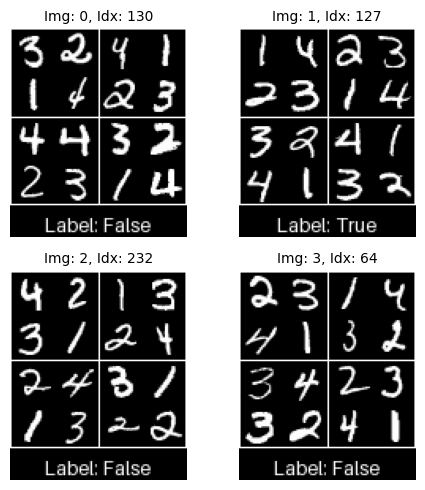

In [108]:
n_chosens = 4
chosen_indices = torch.randperm(n_boards)[:n_chosens]

images = torch.zeros((n_chosens, n_symbols_per_side * symbol_size, n_symbols_per_side * symbol_size), dtype=torch.uint8)
for k, board_index in enumerate(chosen_indices):
    for counter, (i, j) in enumerate(indices[k]):
        images[k, i * symbol_size:(i + 1) * symbol_size, j * symbol_size:(j + 1) * symbol_size] = symbols[board_index, counter, :, :]
    for l in range(n_blocks + 1):
        images[k, min(images.shape[1] - 1,  l * symbol_size * n_blocks), :] = 255
        images[k, :, min(images.shape[2] - 1,  l * symbol_size * n_blocks)] = 255

bottom_padding = 20
pil_image_list = list[Image.Image]()
for k in range(n_chosens):
    raw_pil_image = Image.fromarray(images[k].numpy(), mode='L')
    pil_image = Image.new('L', (raw_pil_image.width, raw_pil_image.height + bottom_padding), 0)
    pil_image.paste(raw_pil_image, (0, 0))
    text = f'Label: {labels[chosen_indices[k]].item()}'
    draw = ImageDraw.Draw(pil_image)
    font = ImageFont.load_default(12)
    bbox = draw.textbbox((0, 0), text, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    text_x = (pil_image.width - text_width) // 2
    text_y = raw_pil_image.height + (bottom_padding - text_height) // 2
    draw.text((text_x, text_y), text, fill=255, font=font)
    pil_image_list.append(pil_image)

base64_image_list = []
for pil_image in pil_image_list:
    buffer = io.BytesIO()
    pil_image.save(buffer, format='PNG')
    buffer.seek(0)
    base64_image_list.append(base64.b64encode(buffer.read()).decode('utf-8'))

n_rows = torch.floor(torch.tensor(n_chosens ** 0.5)).int().item()
n_cols = torch.ceil(torch.tensor(n_chosens / n_rows)).int().item()
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 2.5, n_rows * 2.5))
for k, ax in enumerate(axs.flatten()):
    ax.axis('off')
    if k < n_chosens:
        ax.imshow(pil_image_list[k], cmap='gray')
        ax.set_title(f'Img: {k}, Idx: {chosen_indices[k]}', fontsize=10)
fig.tight_layout()
fig.show()

for k in range(n_chosens):
    print(f'Img: {k}, Idx: {chosen_indices[k]}, lbl: {labels[chosen_indices[k]].item()}')
    board = torch.zeros((n_symbols_per_side, n_symbols_per_side), dtype=torch.int32)
    for counter, (i, j) in enumerate(indices[chosen_indices[k]]):
        board[i, j] = digits[chosen_indices[k], counter]
    print(board)

## llama-4-maverick-17b-128e-instruct

In [104]:
ltn_builder = LTNBuilder()
client = Groq(api_key=GROQ_API_KEY)

In [112]:
x = torch.cat([digits.unsqueeze(-1), indices], dim=-1)

extracted_fol_rule = ''
accuracy = None

for t in range(10):

    print(f'Trial {t+1}')

    system_role = (
        'You are a helpful assistant that can extract the First-Order Logic (FOL) from images.'
        '\nThe grammar of the FOL is as follows:'
        '\n- No constants are allowed.'
        '\n- A variable is any visual object, which is always `x`, `x1`, or `x2`.'
        '\n- No functions are allowed.'
        '\n- You must used only these predicates `P_same_row(x1, x2)`, `P_same_col(x1, x2)`, `P_same_block(x1, x2)`, `P_same_loc(x1, x2)`, `P_same_value(x1, x2)`, '
        '\n- To compare variables, only use predicates!'
        '\n- The symbols for AND, OR, and NOT are `&`, `|`, and `!` respectively.'
        '\n- The symbols for implication and equivalence are `implies` and `iff` respectively.'
        '\n- The symbols for universal and existential quantifiers are `forall` and `exists` respectively.'
        '\n- Use parentheses for every operation'
        '\nAct based on the following:'
        '\n- Use your own knowledge to analyze and deeply think about the images.'
        '\n- Consider that all the images must follow the same rule.'
        '\n- The FOL rule applies to the visual objects inside each image.'
        '\n- At the end of your chain of thought, put the extracted FOL rules in the following template:'
        '\n  EXTRACTED_RULE: "the rule you extracted"'
    )
    if extracted_fol_rule != '':
        system_role += (
            '\nNOTES:'
            '\n  - You previously extracted: "' + extracted_fol_rule + '"'
        )
        if accuracy is None:
            system_role += (
                '\n  - The rule parser was not able to parse that!'
            )
        else:
            system_role += (
                '\n  - The rule was applied to ' + str(x.shape[0]) + ' images.'
                '\n  - From the images, the rule only worked on ' + str(int(x.shape[0] * accuracy )) + ' iamges.'
            )

    prompt = [{'type': 'text', 'text': 'These are some images you can use as reference:'}]
    for k in range(n_chosens):
        prompt.append({'type': 'image_url', 'image_url': {'url': f'data:image/png;base64,{base64_image_list[k]}'}})

    chat_completion = client.chat.completions.create(
        messages=[
            {'role': 'system', 'content': system_role},
            {'role': 'user', 'content': prompt}
        ],
        model='meta-llama/llama-4-maverick-17b-128e-instruct',
    )

    try:
        response = chat_completion.choices[0].message.content
        extracted_fol_rule:str = re.search(r'EXTRACTED_RULE\s*:\s*"([^"]*)"', response).group(1)
        print(f'  Extracted Rule: {extracted_fol_rule}')
    except:
        extracted_fol_rule = 'ERROR'
        accuracy = None
        print('')
        continue

    try:
        ltn_formula = ltn_builder.make_formula(extracted_fol_rule)
    except:
        print()
        accuracy = None
        continue

    ltn_formula.ground(
        P_same_row=row_similarity,
        P_same_col=col_similarity,
        P_same_block=block_similarity,
        P_same_loc=loc_similarity,
        P_same_value=digit_similarity,
        forall='godel',
        implies='godel',
        and_='godel',
        or_='godel',
        not_='godel'
    )
    prediction = ltn_formula(
        x1=x,
        x2=x
    )
    accuracy = (prediction == labels).float().mean().item()
    print(f'  Accuracy: {accuracy}')
    print()

Trial 1
  Extracted Rule: forall x1 forall x2 ((P_same_row(x1, x2) | P_same_col(x1, x2) | P_same_block(x1, x2)) & !P_same_loc(x1, x2) implies !P_same_value(x1, x2))
forall[x1](forall[x2](((P_same_row(x1, x2) | P_same_col(x1, x2) | P_same_block(x1, x2)) & !(P_same_loc(x1, x2) implies !(P_same_value(x1, x2))))))
  Accuracy: 0.46484375

Trial 2
  Extracted Rule: forall x1 forall x2 ((P_same_row(x1, x2) | P_same_col(x1, x2) | P_same_block(x1, x2)) & !P_same_loc(x1, x2) implies !P_same_value(x1, x2))
forall[x1](forall[x2](((P_same_row(x1, x2) | P_same_col(x1, x2) | P_same_block(x1, x2)) & !(P_same_loc(x1, x2) implies !(P_same_value(x1, x2))))))
  Accuracy: 0.46484375

Trial 3

Trial 4

Trial 5
  Extracted Rule: forall x1 forall x2 (P_same_row(x1, x2) | P_same_col(x1, x2) | P_same_block(x1, x2)) implies !P_same_value(x1, x2)
forall[x1](forall[x2]((P_same_row(x1, x2) | P_same_col(x1, x2) | P_same_block(x1, x2)) implies !(P_same_value(x1, x2))))
  Accuracy: 0.46484375

Trial 6

Trial 7


KeyboardInterrupt: 